In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.distributions.bijectors

tfe = tf.contrib.eager
tfe.enable_eager_execution()

import numpy as np

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sharan/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/sharan/.local/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:55: DeprecationWarning: inspect.getargspec() is deprecated

In [128]:
import threading
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
norm = tfd.Normal(loc=0., scale=1.)
prob = norm.prob(0.)
cdf = norm.cdf(0.)
logp = norm.log_prob(0.)

In [4]:
norm.mean()

<tf.Tensor: id=42, shape=(), dtype=float32, numpy=0.0>

In [5]:
norm.entropy()

<tf.Tensor: id=49, shape=(), dtype=float32, numpy=1.4189385>

In [6]:
norm.mode()

<tf.Tensor: id=53, shape=(), dtype=float32, numpy=0.0>

# Resources
https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Understanding_TensorFlow_Distributions_Shapes.ipynb

In [7]:
norm.sample(sample_shape=5)

<tf.Tensor: id=73, shape=(5,), dtype=float32, numpy=
array([ 0.8021493 , -0.32492748,  0.98530126,  0.35352242,  1.6569341 ],
      dtype=float32)>

In [9]:
# tfp.mcmc.MetropolisHastings()

In [10]:
class Context(object):
    """Functionality for objects that put themselves in a context using
    the `with` statement.
    """
    contexts = threading.local()

    def __enter__(self):
        type(self).get_contexts().append(self)
        return self

    def __exit__(self, typ, value, traceback):
        type(self).get_contexts().pop()

def withparent(meth):
    """Helper wrapper that passes calls to parent's instance"""
    def wrapped(self, *args, **kwargs):
        res = meth(self, *args, **kwargs)
        if getattr(self, 'parent', None) is not None:
            getattr(self.parent, meth.__name__)(*args, **kwargs)
        return res
    # Unfortunately functools wrapper fails
    # when decorating built-in methods so we
    # need to fix that improper behaviour
    wrapped.__name__ = meth.__name__
    return wrapped

class treedict(dict):
    """A dict that passes mutable extending operations used in Model
    to parent dict instance.
    Extending treedict you will also extend its parent
    """
    def __init__(self, iterable=(), parent=None, **kwargs):
        super(treedict, self).__init__(iterable, **kwargs)
        assert isinstance(parent, dict) or parent is None
        self.parent = parent
        if self.parent is not None:
            self.parent.update(self)
    # typechecking here works bad
    __setitem__ = withparent(dict.__setitem__)
    update = withparent(dict.update)

    def tree_contains(self, item):
        # needed for `add_random_variable` method
        if isinstance(self.parent, treedict):
            return (dict.__contains__(self, item) or
                    self.parent.tree_contains(item))
        elif isinstance(self.parent, dict):
            return (dict.__contains__(self, item) or
                    self.parent.__contains__(item))
        else:
            return dict.__contains__(self, item)

In [216]:
class Model(Context):
    def __new__(cls, *args, **kwargs):
        instance = super(Model, cls).__new__(cls)
        if kwargs.get('model') is not None:
            instance.parent = kwargs.get('model')
        elif cls.get_contexts():
            instance.parent = cls.get_contexts()[-1]
        else:
            instance.parent = None
        return instance
    
    def __init__(self, name="", model=None, ):
        self.name = name
        if self.parent is not None:
            self.named_vars = treedict(parent=self.parent.named_vars)
        else:
            self.named_vars = treedict()
        
    
    @property
    def model(self):
        return self
    
    @property
    def decription(self):
        return 
    
    @classmethod
    def get_contexts(cls):
        # no race-condition here, cls.contexts is a thread-local object
        # be sure not to override contexts in a subclass however!
        if not hasattr(cls.contexts, 'stack'):
            cls.contexts.stack = []
        return cls.contexts.stack

    @classmethod
    def get_context(cls):
        """Return the deepest context on the stack."""
        try:
            return cls.get_contexts()[-1]
        except IndexError:
            raise TypeError("No context on context stack")
            
    
    def add_random_variable(self, var):
        """Add a random variable to the named variables of the model."""
        if self.named_vars.tree_contains(var.name):
            raise ValueError(
                "Variable name {} already exists.".format(var.name))
        self.named_vars[var.name] = var

def modelcontext(model):
    """return the given model or try to find it in the context if there was
    none supplied.
    """
    if model is None:
        return Model.get_context()
    return model

#To sample from a defined model with one or more random variable. Most
def sample(draws=500):
    model = Model.get_context()
#     sample = tf.Tensor()
    for i , j in enumerate(model.named_vars):
        print(model.named_vars[j])
        #Using default sampling method provided by TF for now.
        if i:
#             print(sample.shape)
            sample = tf.concat([sample, tf.reshape(model.named_vars[j].sample(sample_shape=(draws)), [-1])], -1)
            
        else:
#             sample = tf.reshape(model.named_vars[j].sample(sample_shape=(draws)), [1, -1])
            sample = model.named_vars[j].sample(sample_shape=(draws))
#             print(sample.shape)
    sample = tf.reshape(trace, [len(model.named_vars), draws])
    return sample
#     sample(sample_shape=(), seed=None, name='sample', **condition_kwargs)

def plot(trace):
    for i in range(trace.shape[0]):
        sns.distplot(trace.numpy()[i])
        plt.show()
        plt.plot(trace.numpy()[i])
        plt.show()

In [217]:
class Normal(tfd.Normal):
    def __init__(self,
                 loc,
                scale,
                validate_args=False,
                allow_nan_stats=True,
                name="Normal"):
        #getting the model from context. useful for the pymc3 way of defining models using with statements
        self.model = Model.get_context()
        super(Normal, self).__init__(
                 loc,
               scale,
               validate_args,
               allow_nan_stats,
               name)
        self.model.add_random_variable(self)
    
    def logp(self, x):
        return self.log_prob(x)
            

In [218]:
with Model(name="Model1") as model1:
    normal = Normal(loc=0., scale=1., name="norm")
    normal1 = Normal(loc=0., scale=1., name="norm1")
    normal2 = Normal(loc=0., scale=1., name="norm2")
    trace = sample(draws=15000)
print(model1.named_vars)

normal.logp(0.)

tf.distributions.Normal("norm", batch_shape=(), event_shape=(), dtype=float32)
tf.distributions.Normal("norm1", batch_shape=(), event_shape=(), dtype=float32)
tf.distributions.Normal("norm2", batch_shape=(), event_shape=(), dtype=float32)
{'norm': <tf.distributions.Normal 'norm' batch_shape=() event_shape=() dtype=float32>, 'norm1': <tf.distributions.Normal 'norm1' batch_shape=() event_shape=() dtype=float32>, 'norm2': <tf.distributions.Normal 'norm2' batch_shape=() event_shape=() dtype=float32>}


<tf.Tensor: id=1840, shape=(), dtype=float32, numpy=-0.9189385>

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


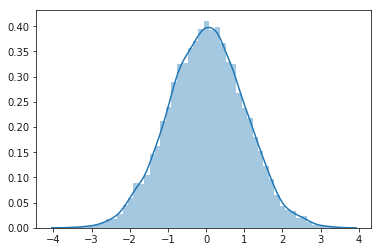

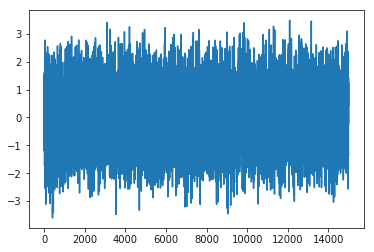

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


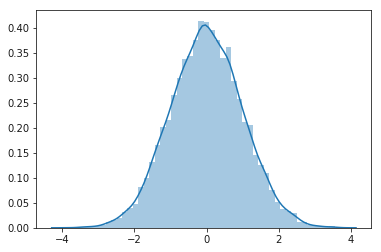

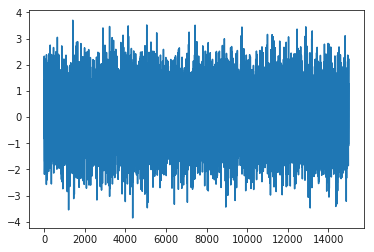

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


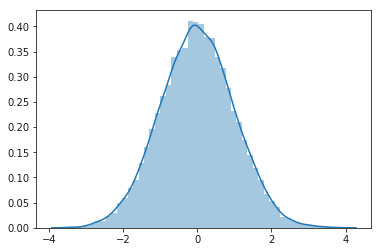

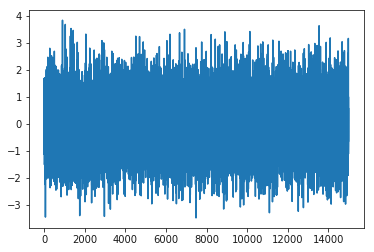

In [220]:
plot(trace)

In [15]:
import pymc3 as pm
with pm.Model() as model:
    normal = pm.Normal("normal", mu=2)
    normal = pm.Normal("normal1")
    print(model.logpt)
    trace = pm.sample(draws=100)

/home/sharan/anaconda3/envs/pymc3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/sharan/anaconda3/envs/pymc3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  re

__logp


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [normal1, normal]
100%|██████████| 600/600 [00:00<00:00, 649.67it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by unknown process (I am process '16409')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sharan/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '16408' (I am process '16410')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sharan/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '16409' (I am process '16410')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/sharan/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.5-64/lock_dir


In [86]:
model.named_vars

{'normal': normal, 'normal1': normal1}

In [80]:
[i for i in trace]

[{'normal': 1.9136205555221821, 'normal1': 1.416924236748485},
 {'normal': 0.7524451534563756, 'normal1': -1.8007141758343854},
 {'normal': 0.10100834100611189, 'normal1': 0.7359145400115086},
 {'normal': 2.9523436087657884, 'normal1': -0.9993062810340347},
 {'normal': 2.218206907493638, 'normal1': -0.745970481448931},
 {'normal': 0.7635045066930664, 'normal1': 1.7659128513603983},
 {'normal': 1.3480132528981128, 'normal1': 1.853755245676555},
 {'normal': 1.5055003055534635, 'normal1': -1.3299212992287863},
 {'normal': 1.5055003055534635, 'normal1': -1.3299212992287863},
 {'normal': 1.6676839953257478, 'normal1': -1.4567018810664722},
 {'normal': 1.1917473526802342, 'normal1': 0.154273254738734},
 {'normal': 3.008119847650455, 'normal1': -0.20530893096739936},
 {'normal': 3.008119847650455, 'normal1': -0.20530893096739936},
 {'normal': 1.4077896859557266, 'normal1': -0.8353727441132827},
 {'normal': 3.5735550765291886, 'normal1': -0.0379503811872135},
 {'normal': 1.4887342847470064, 'n